**recsys-cluster-loss**

Exemplo de análise de agrupamento no contexto de sistemas de recomendação.
Os usuários que recebem as recomendações serão agrupados à partir da medida de justiça individual dessas recomendações.
Tem-se por objetivo analisar se existe algum tipo de injustiça de grupos não óbvios de usuários, ou seja, grupos que não possam ser configurados à partir de alguma característica (variável) explícita dos usuários (por exemplo: sexo, idade, etc.).

Serão aplicados dois métodos de agrupamento:
1. Agrupamento aglomerativo hierárquico (agrupamento em árvore - dendograma)
2. Agrupamento não-hierárquico por repartição (agrupamento por k-Médias)

Neste arquivo estamos analisando os possíveis agrupamentos considerando a(s) seguinte(s) variável(is):
- loss: injustiça individual
- age: age of users
- occupation: occupation of users

Sistema de recomendação: gerando a matriz de recomendação e calculando a justiça individual

In [57]:
# cloning repository with database
!rm -rf recsys-cluster-loss
!git clone https://github.com/ravarmes/recsys-cluster-loss.git

Cloning into 'recsys-cluster-loss'...


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [59]:
import sys
sys.path.append('recsys-cluster-loss/src')
from ArticleAntidoteData import ArticleAntidoteData
from ArticleAntidoteData import IndividualLossVariance

In [60]:
# reading data from 3883 movies and 6040 users 
Data_path = 'recsys-cluster-loss/data/MovieLens-1M'
n_users=  300
n_movies= 1000
top_users = True # True: to use users with more ratings; False: otherwise
top_movies = False # True: to use movies with more ratings; False: otherwise

In [61]:
# recommendation algorithm
algorithm = 'RecSysALS'

In [62]:
# parameters for calculating fairness measures
l = 5
theta = 3
k = 3

In [63]:
article = ArticleAntidoteData(n_users, n_movies, top_users, top_movies, l, theta, k)

In [64]:
X, genres, user_info = article.read_movieitems(n_users, n_movies, top_users, top_movies, data_dir = Data_path) # returns matrix of ratings with n_users rows and n_moveis columns
omega = ~X.isnull() # matrix X with True in cells with evaluations and False in cells not rated

In [65]:
user_info

,Gender,Age,Occupation,Zip-code
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455
...,...,...,...,...
6036,F,25,15,32603
6037,F,45,1,76006
6038,F,56,1,14706
6039,F,45,0,01060


In [66]:
X_est = article.compute_X_est(X, algorithm, Data_path) # RecSysALS or RecSysKNN or RecSysNMF or RecSysExampleAntidoteData20Items

In [67]:
ilv = IndividualLossVariance(X, omega, 1)
losses = ilv.get_losses(X_est)

In [68]:
losses

UserID
4169    0.611130
1680    1.132248
4277    0.414079
1941    1.047745
1181    0.587892
          ...   
3320    1.072202
3462    0.875762
5011    0.664776
308     0.358923
1333    1.164655
Length: 300, dtype: float64

In [69]:
df = pd.DataFrame(columns=['Gender', 'Age', 'Occupation', 'Zip-code', 'Loss'])
df['Gender'] = user_info['Gender']
df['Age'] = user_info['Age']
df['Occupation'] = user_info['Occupation']
df['Zip-code'] = user_info['Zip-code']
df['Loss'] = losses

df.dropna(subset=['Loss'], inplace=True) #Eliminando as linhas com valores vazios na coluna 'Loss'
df

,Gender,Age,Occupation,Zip-code,Loss
48,M,25,4,92107,0.370556
53,M,25,0,96931,0.516604
123,M,35,9,67208,0.487140
148,M,50,17,57747,1.033793
149,M,25,1,29205,0.607217
...,...,...,...,...,...
5916,M,50,20,48230,0.563316
5954,M,45,11,70802,1.492428
5996,F,25,0,87114,0.751011
6016,M,45,1,37209,0.591682


In [70]:
df.head()

,Gender,Age,Occupation,Zip-code,Loss
48,M,25,4,92107,0.370556
53,M,25,0,96931,0.516604
123,M,35,9,67208,0.487140
148,M,50,17,57747,1.033793
149,M,25,1,29205,0.607217


In [71]:
# Número de linhas e colunas:
df.shape

(300, 5)

In [72]:
# Estatística Descritiva:
df.describe()

,Age,Occupation,Loss
count,300.000000,300.000000,300.000000
mean,28.776667,7.070000,0.788955
std,10.259515,6.641194,0.307327
min,1.000000,0.000000,0.293217
25%,25.000000,1.000000,0.578627
50%,25.000000,4.000000,0.727145
75%,35.000000,14.000000,0.915155
max,56.000000,20.000000,2.401739


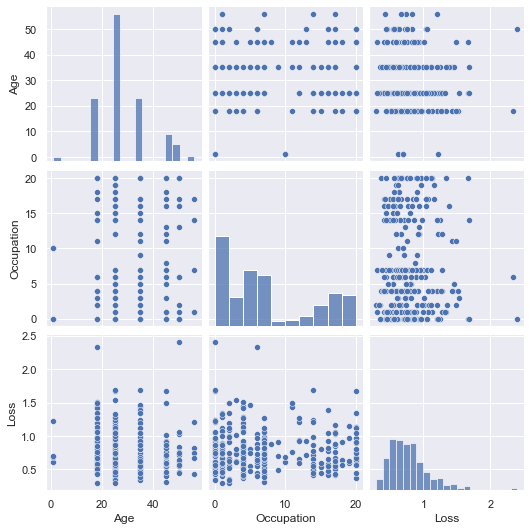

In [73]:
sns.pairplot(df)

<AxesSubplot:>

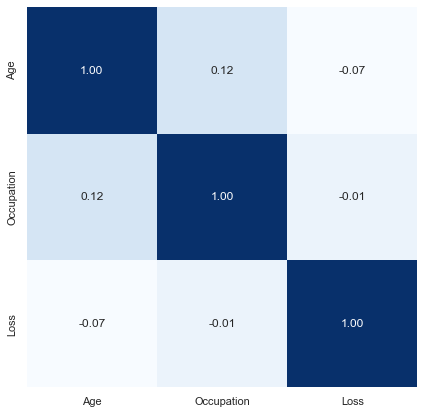

In [74]:
df2 = df.drop(['Gender', 'Zip-code'] , axis=1) # Eliminando as colunas Gender e Zip-code (não numéricas) para analisar as correlações

plt.figure(figsize=(7, 7))
corr = np.corrcoef(df2.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', cbar=False, xticklabels=df2.columns, yticklabels=df2.columns)

Agrupamento aglomerativo hierárquico (agrupamento em árvore - dendograma)

In [75]:
# Deixando apenas a coluna loss para realizar a análise de agrupamento
#df2 = df2.drop('Age', 1) 
#df2 = df2.drop('Occupation', 1) 

In [76]:
df_scaled = df2.copy()
df_scaled.iloc[:, :] = StandardScaler().fit_transform(df2)

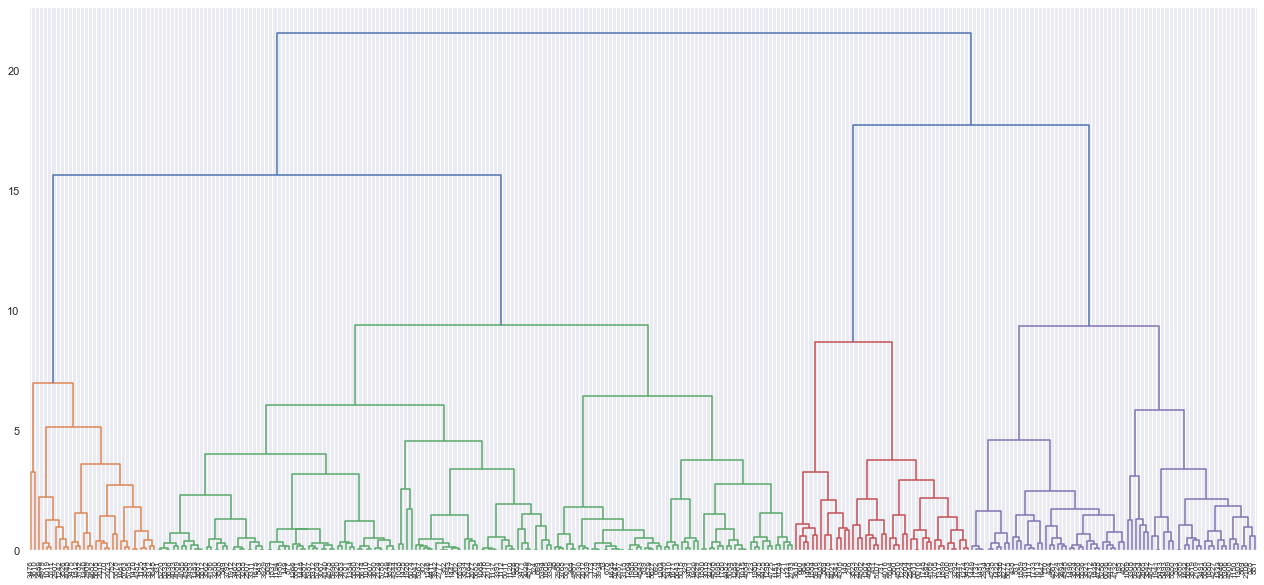

In [77]:
Z = hierarchy.linkage(df_scaled, 'ward') #complete or ward
plt.figure(figsize=(22, 10))
plt.grid(axis='y')
dn = hierarchy.dendrogram(Z, labels=list(df.index), leaf_font_size=8)

In [78]:
n_clusters = 3
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
groups = cluster.fit_predict(df2)

In [79]:
groups

array([1, 1, 0, 0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 2, 2, 2, 1, 1,
       2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1, 2, 1, 2, 0, 0,
       1, 0, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 2, 0, 2, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 2,
       2, 1, 2, 0, 1, 1, 2, 0, 2, 0, 0, 0, 1, 1, 0, 2, 2, 1, 0, 0, 2, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       2, 2, 2, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 0, 2,
       1, 2, 0, 1, 1, 0, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1, 1, 1, 2,
       0, 2, 1, 1, 0, 0, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 2, 0, 0, 0, 2, 1, 2, 0, 1, 1, 1, 0, 0, 2, 0, 2, 0, 1, 1,
       1, 0, 1, 0, 2, 2, 0, 0, 2, 1, 0, 1, 0, 2, 2, 0, 1, 0, 0, 0, 1, 2,
       2, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 0, 2], d

In [80]:

users = list(df2.index)
grouped_users = {i: [] for i in range(n_clusters)}
for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}\n')

Cluster 0: [123, 148, 216, 245, 319, 329, 411, 550, 660, 721, 731, 889, 984, 1015, 1019, 1181, 1207, 1224, 1242, 1274, 1285, 1298, 1317, 1422, 1449, 1451, 1465, 1671, 1698, 1737, 1741, 1748, 1780, 1880, 1884, 1897, 1899, 1920, 1941, 1980, 2092, 2304, 2529, 2544, 2665, 2793, 2820, 2878, 2907, 2934, 2962, 3018, 3272, 3292, 3336, 3401, 3410, 3476, 3483, 3526, 3589, 3618, 3675, 3705, 3724, 3823, 3841, 3842, 3999, 4016, 4021, 4048, 4054, 4064, 4083, 4169, 4238, 4277, 4305, 4354, 4425, 4447, 4482, 4510, 4647, 4725, 4802, 4808, 4979, 5015, 5054, 5100, 5107, 5111, 5433, 5493, 5504, 5511, 5550, 5643, 5675, 5916, 5954, 6016]

Cluster 1: [48, 53, 149, 173, 202, 302, 308, 331, 352, 509, 524, 543, 549, 678, 692, 699, 752, 770, 839, 855, 877, 1010, 1050, 1051, 1068, 1088, 1112, 1120, 1125, 1137, 1194, 1203, 1246, 1264, 1266, 1340, 1354, 1383, 1425, 1447, 1448, 1470, 1579, 1605, 1635, 1675, 1676, 1749, 1764, 1837, 1912, 1926, 1943, 1958, 1988, 2010, 2012, 2015, 2030, 2063, 2073, 2077, 2116, 2124, 218

Agrupamento não-hierárquico por repartição (agrupamento por k-Médias)

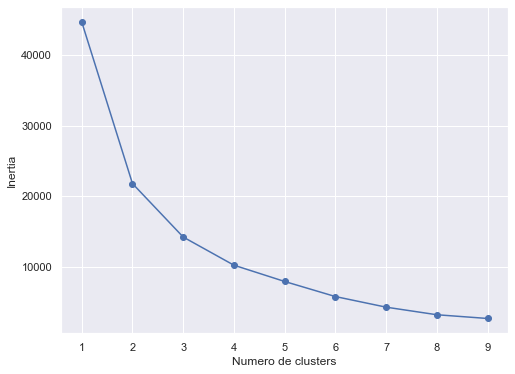

In [81]:
inertias = []
for k in np.arange(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df2)
    inertias.append(kmeans.inertia_)

# Plotando o gráfico do Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 10), inertias, '-o')
plt.xlabel('Numero de clusters')
plt.ylabel('Inertia');

In [82]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
df_scaled['cluster'] = kmeans.fit_predict(df_scaled)

In [83]:
df_scaled

,Age,Occupation,Loss,cluster
48,-0.368729,-0.463039,-1.363689,0
53,-0.368729,-1.066346,-0.887673,0
123,0.607605,0.291096,-0.983708,1
148,2.072105,1.497711,0.797999,1
149,-0.368729,-0.915519,-0.592339,0
...,...,...,...,...
5916,2.072105,1.950192,-0.735427,1
5954,1.583938,0.592750,2.292827,1
5996,-0.368729,-1.066346,-0.123673,0
6016,1.583938,-0.915519,-0.642972,1


In [84]:
users = list(df_scaled.index)
groups = df_scaled['cluster']

grouped_users = {i: [] for i in range(n_clusters)}

for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}\n')

Cluster 0: [48, 53, 149, 173, 202, 302, 308, 331, 352, 509, 524, 543, 549, 678, 692, 699, 752, 770, 839, 855, 877, 1010, 1019, 1050, 1051, 1068, 1088, 1112, 1120, 1125, 1137, 1194, 1203, 1242, 1246, 1264, 1266, 1340, 1354, 1383, 1425, 1447, 1448, 1470, 1579, 1605, 1635, 1671, 1675, 1676, 1749, 1764, 1837, 1912, 1926, 1943, 1958, 1988, 2010, 2012, 2015, 2030, 2063, 2073, 2077, 2116, 2124, 2181, 2453, 2507, 2777, 2820, 2857, 2887, 2907, 2909, 2986, 3029, 3032, 3067, 3118, 3280, 3285, 3311, 3312, 3320, 3389, 3391, 3410, 3462, 3471, 3507, 3526, 3539, 3562, 3610, 3648, 3650, 3681, 3683, 3768, 3778, 3792, 3808, 3829, 3834, 3884, 3929, 3934, 3942, 4033, 4041, 4048, 4085, 4089, 4140, 4186, 4344, 4386, 4387, 4411, 4543, 4578, 4579, 4682, 4957, 4979, 5011, 5074, 5111, 5220, 5312, 5333, 5367, 5387, 5394, 5501, 5530, 5605, 5614, 5627, 5636, 5643, 5682, 5747, 5759, 5763, 5788, 5795, 5812, 5831, 5878, 5880, 5996]

Cluster 1: [123, 148, 216, 319, 329, 411, 550, 660, 721, 731, 984, 1015, 1181, 1207, 1